#Mount the google drive to access the files

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [28]:
import torch
from torchvision import datasets, transforms


#Check CUDA availability

In [5]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

CUDA Available? False


#Transformations for training data

In [7]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

#Download dataset and store in train_data and test_data

In [8]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 117708527.37it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 27045254.26it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 23575080.78it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4231570.14it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



#Load using data loader

In [9]:
batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

#Visualise the data using matplotlib

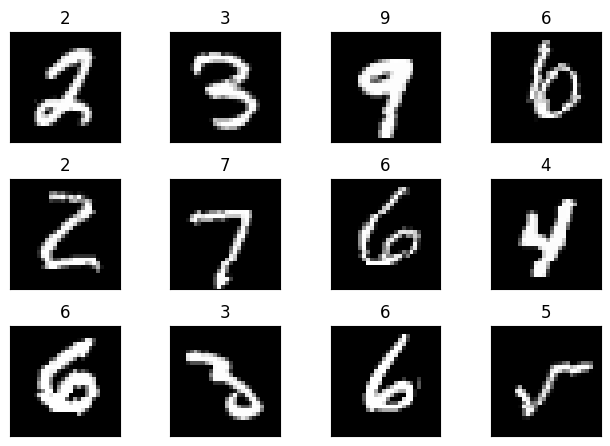

In [10]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

#Upload the model.py file to the local drive

In [13]:
from google.colab import files
files.upload()

Saving model.py to model.py


{'model.py': b'#import necessary liberary \r\nimport torch\r\nimport torch.nn as nn\r\nimport torch.nn.functional as F\r\nimport torch.optim as optim\r\n\r\n#model definition\r\nclass Net(nn.Module):\r\n    #This defines the structure of the NN.\r\n    def __init__(self):\r\n        super(Net, self).__init__()\r\n        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)\r\n        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)\r\n        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)\r\n        self.conv4 = nn.Conv2d(128, 256, kernel_size=3)\r\n        self.fc1 = nn.Linear(4096, 50)\r\n        self.fc2 = nn.Linear(50, 10)\r\n\r\n    def forward(self, x):\r\n        x = F.relu(self.conv1(x), 2)\r\n        x = F.relu(F.max_pool2d(self.conv2(x), 2))\r\n        x = F.relu(self.conv3(x), 2)\r\n        x = F.relu(F.max_pool2d(self.conv4(x), 2))\r\n        x = x.view(-1, 4096)\r\n        x = F.relu(self.fc1(x))\r\n        x = self.fc2(x)\r\n        return F.log_softmax(x, dim=1)\r\n\r\n'}

#Import the model.py file

In [24]:
import model

##check model layer

In [25]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = model.Net().to(device) #Net function in the model.py is accessed here
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
            Conv2d-3          [-1, 128, 10, 10]          73,856
            Conv2d-4            [-1, 256, 8, 8]         295,168
            Linear-5                   [-1, 50]         204,850
            Linear-6                   [-1, 10]             510
Total params: 593,200
Trainable params: 593,200
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 2.26
Estimated Total Size (MB): 2.94
----------------------------------------------------------------


#Import the utility file- utils.py


In [32]:
files.upload()

Saving utils.py to utils (1).py


{'utils (1).py': b"\r\nfrom tqdm import tqdm\r\nimport torch\r\nimport torch.optim as optim\r\nimport torch.nn.functional as F\r\n\r\n# Data to plot accuracy and loss graphs\r\ntrain_losses = []\r\ntest_losses = []\r\ntrain_acc = []\r\ntest_acc = []\r\n\r\ntest_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}\r\n\r\n\r\ndef GetCorrectPredCount(pPrediction, pLabels):\r\n  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()\r\n\r\ndef train(model, device, train_loader, optimizer, criterion):\r\n  model.train()\r\n  pbar = tqdm(train_loader)\r\n\r\n  train_loss = 0\r\n  correct = 0\r\n  processed = 0\r\n\r\n  for batch_idx, (data, target) in enumerate(pbar):\r\n    data, target = data.to(device), target.to(device)\r\n    optimizer.zero_grad()\r\n\r\n    # Predict\r\n    pred = model(data)\r\n\r\n    # Calculate loss\r\n    loss = criterion(pred, target)\r\n    train_loss+=loss.item()\r\n\r\n    # Backpropagation\r\n    loss.backward()\r\n    optimizer.step(

Load the function in utils file

In [33]:
import utils

In [37]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model = model.Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
# New Line
criterion = F.nll_loss
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  utils.train(model, device, train_loader, optimizer, criterion)
  utils.test(model, device, test_loader, criterion)
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=0.2705 Batch_id=117 Accuracy=53.17: 100%|██████████| 118/118 [07:20<00:00,  3.73s/it]


Test set: Average loss: 0.2209, Accuracy: 9326/10000 (93.26%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.3552 Batch_id=117 Accuracy=94.09: 100%|██████████| 118/118 [06:40<00:00,  3.39s/it]


Test set: Average loss: 0.0905, Accuracy: 9717/10000 (97.17%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.0361 Batch_id=117 Accuracy=96.41: 100%|██████████| 118/118 [06:40<00:00,  3.40s/it]


Test set: Average loss: 0.0601, Accuracy: 9823/10000 (98.23%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.0852 Batch_id=117 Accuracy=97.15: 100%|██████████| 118/118 [06:57<00:00,  3.54s/it]


Test set: Average loss: 0.0552, Accuracy: 9827/10000 (98.27%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=0.0687 Batch_id=67 Accuracy=97.47:  58%|█████▊    | 68/118 [03:56<02:53,  3.47s/it]


KeyboardInterrupt: 

#Plot detailed graph

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(utils.train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(utils.train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(utils.test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(utils.test_acc)
axs[1, 1].set_title("Test Accuracy")